In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

from fire_model.ca import FireEnv, FireState, CAFireModel

In [2]:
# ENHANCED PARAMETERS FOR MORE VISIBLE EFFECT
# Note: retardant_k is now set to 20.0 in the env creation cell below
# This cell is just a placeholder - the actual enhancement happens in the env creation
print("Enhanced parameters will be applied in env creation")

Enhanced parameters will be applied in env creation


In [3]:
nx = ny = 120
domain_km = 2.0

fuel = np.ones((nx, ny))
value = np.ones((nx, ny))

wind = np.zeros((nx, ny, 2))
wind[..., 0] = 5.0   # east wind
wind[..., 1] = 0.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=3.0,
    burn_time_s0=600.0,
    retardant_half_life_s=3600.0,
    retardant_k=20.0,  # Increased from 10.0 for more visible effect
    drop_w_km=0.04,
    drop_h_km=0.12,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
)
model = CAFireModel(env, seed=0)


In [4]:
def lookahead_affected(state, T_look=90.0, n_sims=50):
    """
    Short-horizon fire forecast WITHOUT retardant.
    Used only to estimate the future fire front.
    """
    tmp = model.simulate_from_firestate(
        state,
        T=T_look,
        n_sims=n_sims,
    )
    return np.clip(tmp.burning[0] + tmp.burned[0], 0, 1)

In [5]:
p_init = np.zeros((nx, ny))
cx, cy = nx//2, ny//2
p_init[cx-3:cx+3, cy-3:cy+3] = 1.0

init_state = FireState(
    burning=p_init[None],
    burned=np.zeros((1, nx, ny)),
    burn_remaining_s=np.full((1, nx, ny), env.burn_time_s0),
    retardant=np.zeros((1, nx, ny)),
    t=0,
)

In [6]:
final_baseline = model.simulate_from_firestate(
    init_state,
    T=300.0,
    n_sims=100,
)

affected_baseline = np.clip(
    final_baseline.burning[0] + final_baseline.burned[0], 0, 1
)

baseline_loss = np.sum(affected_baseline * env.value)
print("Baseline loss:", baseline_loss)

No drone_params
Baseline loss: 8222.49


In [7]:
# Debug the heuristic calculation
burning = init_state.burning[0]  # Fixed: use init_state instead of state_h
print("burning shape:", burning.shape)
print("burning dtype:", burning.dtype)
print("burning min/max:", burning.min(), burning.max())
print("burning > 0 count:", np.sum(burning > 0))

coords = np.column_stack(np.where(burning > 0))
print("coords shape:", coords.shape)
print("coords range i:", coords[:, 0].min(), "to", coords[:, 0].max())
print("coords range j:", coords[:, 1].min(), "to", coords[:, 1].max())

w = env.wind.mean(axis=(0,1))
print("wind:", w)
w_hat = w / np.linalg.norm(w)
print("w_hat:", w_hat)

proj = coords @ w_hat
print("proj min/max:", proj.min(), proj.max())
cut = np.quantile(proj, 0.95)
print("cut (95th percentile):", cut)
head_cells = coords[proj >= cut]
print("head_cells shape:", head_cells.shape)
head = head_cells.mean(axis=0)
print("head (mean of head cells):", head)

burning shape: (120, 120)
burning dtype: float64
burning min/max: 0.0 1.0
burning > 0 count: 36
coords shape: (36, 2)
coords range i: 57 to 62
coords range j: 57 to 62
wind: [5. 0.]
w_hat: [1. 0.]
proj min/max: 57.0 62.0
cut (95th percentile): 62.0
head_cells shape: (6, 2)
head (mean of head cells): [62.  59.5]


In [8]:
def downwind_barrier_from_lookahead(
    init_state,
    T_look=90.0,
    n_sims_look=50,
    front_thresh=0.25,
    n_drops=14,
    offset_cells=6,
    spacing_cells=2,
):
    # 1) Lookahead forecast
    affected = lookahead_affected(init_state, T_look, n_sims_look)

    front_coords = np.column_stack(np.where(affected > front_thresh))
    if len(front_coords) == 0:
        return np.empty((0,3)), affected

    # 2) Wind direction
    w = env.wind.mean(axis=(0,1))
    w_hat = w / (np.linalg.norm(w) + 1e-9)
    perp = np.array([-w_hat[1], w_hat[0]])

    # 3) Head fire = most downwind part of front
    proj = front_coords @ w_hat
    cut = np.quantile(proj, 0.98)
    head_cells = front_coords[proj >= cut]
    head = head_cells.mean(axis=0)

    # 4) Build barrier line
    cell_size_km = env.domain_km / nx
    drops = []

    for k in range(n_drops):
        alpha = k - (n_drops - 1) / 2
        i = head[0] + offset_cells*w_hat[0] + alpha*perp[0]*spacing_cells
        j = head[1] + offset_cells*w_hat[1] + alpha*perp[1]*spacing_cells

        i = np.clip(i, 0, nx-1)
        j = np.clip(j, 0, ny-1)

        x_km = i * cell_size_km
        y_km = j * cell_size_km

        # Long axis perpendicular to wind
        phi = np.arctan2(perp[1], perp[0])
        drops.append((x_km, y_km, phi))

    return np.array(drops), affected

In [9]:
state_h = replace(init_state, retardant=np.zeros_like(init_state.retardant))

drops, affected_look = downwind_barrier_from_lookahead(
    init_state,
    T_look=90.0,
    n_sims_look=50,
    front_thresh=0.25,
    n_drops=14,
    offset_cells=6,
    spacing_cells=2,
)

model.apply_retardant_cartesian(
    state_h,
    drops,
    drop_w_km=0.03,   # IMPORTANT: wider than before
    drop_h_km=0.12,
    amount=1.0,
    avoid_burning=False,
)

No drone_params
Applying retardant drop: D=[[1.47101449 0.77318841 1.57079633]
 [1.47101449 0.80652174 1.57079633]
 [1.47101449 0.83985507 1.57079633]
 [1.47101449 0.87318841 1.57079633]
 [1.47101449 0.90652174 1.57079633]
 [1.47101449 0.93985507 1.57079633]
 [1.47101449 0.97318841 1.57079633]
 [1.47101449 1.00652174 1.57079633]
 [1.47101449 1.03985507 1.57079633]
 [1.47101449 1.07318841 1.57079633]
 [1.47101449 1.10652174 1.57079633]
 [1.47101449 1.13985507 1.57079633]
 [1.47101449 1.17318841 1.57079633]
 [1.47101449 1.20652174 1.57079633]], amount=1.0, drop_w_km=0.03, drop_h_km=0.12


In [10]:
# Check state_h before simulation
print("=== BEFORE SIMULATION ===")
print("state_h.retardant.sum():", state_h.retardant.sum())
print("state_h.retardant.shape:", state_h.retardant.shape)
print("state_h.burning type:", type(state_h.burning))
print("state_h.burning dtype:", state_h.burning.dtype if hasattr(state_h.burning, 'dtype') else 'N/A')
print("state_h.burning shape:", state_h.burning.shape)

final_h = model.simulate_from_firestate(
    state_h,
    T=300.0,
    n_sims=100,
)

affected_h = np.clip(
    final_h.burning[0] + final_h.burned[0], 0, 1
)

heuristic_loss = np.sum(affected_h * env.value)
print("Heuristic loss:", heuristic_loss)

# After sim:
fire_final = affected_h > 0
retardant_placed = state_h.retardant[0] > 0

fire_final = affected_h > 0
retardant_placed = state_h.retardant[0] > 0

print("Retardant cells:", np.sum(retardant_placed))
print("Fire final cells:", np.sum(fire_final))
print("Overlap with final fire:", np.sum(fire_final & retardant_placed))

=== BEFORE SIMULATION ===
state_h.retardant.sum(): 196.0
state_h.retardant.shape: (1, 120, 120)
state_h.burning type: <class 'numpy.ndarray'>
state_h.burning dtype: float64
state_h.burning shape: (1, 120, 120)
No drone_params
Heuristic loss: 7991.98
Retardant cells: 196
Fire final cells: 10070
Overlap with final fire: 0


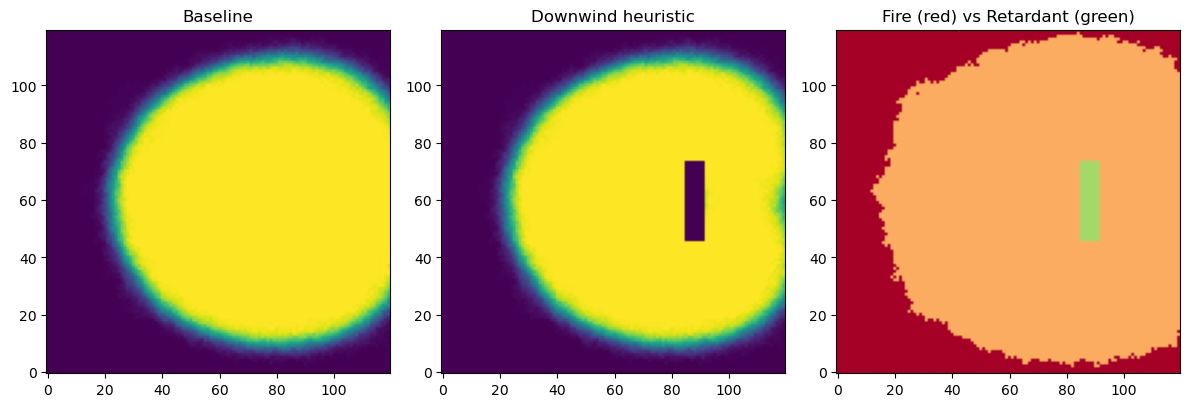

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(affected_baseline.T, origin="lower")
plt.title("Baseline")

plt.subplot(1,3,2)
plt.imshow(affected_h.T, origin="lower")
plt.title("Downwind heuristic")

plt.subplot(1,3,3)
combined = np.zeros((nx, ny))
combined[fire_final] = 0.3
combined[retardant_placed] = 0.7
combined[fire_final & retardant_placed] = 0.5
plt.imshow(combined.T, origin="lower", cmap="RdYlGn", vmin=0, vmax=1)
plt.title("Fire (red) vs Retardant (green)")

plt.tight_layout()
plt.show()